In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from operator import itemgetter as it
from itertools import repeat
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import matplotlib
import readability
import seaborn as sns
from wordcloud import WordCloud

In [4]:
df=pd.read_csv('Data/notebook_aggregated_manifestos.csv')

In [50]:
df.head(88)

Unnamed: 0  year  participation party_name  result  \
0            0  DS_S          61.40      Store   11.00   
1            1  1949          78.49     CDUCSU   31.01   
2            2  1949          78.49        FDP   11.92   
3            3  1949          78.49      Linke     NaN   
4            4  1949          78.49        SPD   29.22   
5            5  1953          85.99     CDUCSU   45.17   
6            6  1953          85.99        FDP    9.54   
7            7  1953          85.99        SPD   28.84   
8            8  1957          87.77     CDUCSU   50.19   
9            9  1957          87.77        FDP    7.71   
10          10  1957          87.77        SPD   31.75   
11          11  1961          87.74     CDUCSU   45.32   
12          12  1961          87.74        FDP   12.77   
13          13  1961          87.74        SPD   36.22   
14          14  1965          86.77     CDUCSU   47.59   
15          15  1965          86.77        FDP    9.49   
16          16  1965          86.77        SPD   39.28   
17          17  1969          86.67     CDUCSU   46.09   
18          18  1969          86.67        FDP    5.77   
19          19  1969          86.67        SPD   42.67   
20          20  1972          91.11     CDUCSU   44.86   
21          21  1972          91.11        FDP    8.36   
22          22  1972          91.11        SPD   45.85   
23          23  1976          90.75     CDUCSU   48.63   
24          24  1976          90.75        FDP    7.92   
25          25  1976          90.75        SPD   42.56   
26          26  1980          88.57     CDUCSU   44.54   
27          27  1980          88.57        FDP   10.62   
28          28  1980          88.57        SPD   42.86   
29          29  1983          89.09     CDUCSU   48.79   
..         ...   ...            ...        ...     ...   
58          58  2005          77.65        FDP    9.83   
59          59  2005          77.65     Gruene    8.12   
60          60  2005          77.65      Linke    8.71   
61          61  2005          77.65        SPD   34.25   
62          62  2009          70.78     CDUCSU   33.80   
63          63  2009          70.78        FDP   14.56   
64          64  2009          70.78     Gruene   10.71   
65          65  2009          70.78      Linke   11.89   
66          66  2009          70.78        SPD   23.03   
67          67  2013          71.55        AFD    4.70   
68          68  2013          71.55     CDUCSU   41.55   
69          69  2013          71.55        FDP    4.76   
70          70  2013          71.55     Gruene    8.44   
71          71  2013          71.55      Linke    8.59   
72          72  2013          71.55        SPD   25.74   
73          73  2017          76.16        AFD   12.64   
74          74  2017          76.16     CDUCSU   32.93   
75          75  2017          76.16        FDP   10.75   
76          76  2017          76.16     Gruene    8.94   
77          77  2017          76.16      Linke    9.24   
78          78  2017          76.16        SPD   20.51   
79          79  1979          65.70     CDUCSU   49.20   
80          80  1979          65.70        FDP    6.00   
81          81  1979          65.70     Gruene    3.20   
82          82  1979          65.70        SPD   40.80   
83          83  1984          56.80     CDUCSU   46.00   
84          84  1984          56.80        FDP    4.80   
85          85  1984          56.80     Gruene    8.20   
86          86  1984          56.80        SPD   37.40   
87          87  1989          62.30     CDUCSU   37.70   

                                                 text type  
0    www.afd.de/europawahlprogramm EUROPAWAHLPROGR...    .  
1    Düsseldorfer Leitsätze vom 15. Juli 1949 Das ...    b  
2   BREMER PLATTFORM 1949  Beschlüsse des 1. Bunde...    b  
3   Einheit, Frieden, Wohlstand Aus dem Wahlprogra...    b  
4   Für ein freies Deutschland    Wählerinnen und ...    b  
5   Hamburger Programm vom 22. April 1053

In [6]:
def get_election_result(year,party):
    working_df=df.loc[df['type'] == 'b']
    res=working_df.loc[(working_df['year'] == year) & (working_df['party_name'] == party)]['result'].values
    if len(res)==1:
        return res[0]
    
    return 0
    

In [7]:
      
text = ('Das ist, unter diesen Umständen, ein viel komplexerer Satz.\n')
results = readability.getmeasures(text, lang='de')
print(results['readability grades'])

OrderedDict([('Kincaid', 7.58666666666667), ('ARI', 8.189999999999998), ('Coleman-Liau', 12.270925777777776), ('FleschReadingEase', 56.70000000000001), ('GunningFogIndex', 8.044444444444444), ('LIX', 31.22222222222222), ('SMOGIndex', 8.477225575051662), ('RIX', 2.0), ('DaleChallIndex', 9.346233333333332)])


In [39]:
def get_docs(df):
    df=df.loc[df['type'] == 'b']
    #df=df.loc[df['year'] == '2017']
    
    index=[]
    for idx, row in df.iterrows():
        index.append(f'{row["year"]}|{row["party_name"]}')
    
    return np.array(df.text), np.array(index)

def spacyfy(docs,nlp):
    spacyfied=[]
    for doc in docs:
        spacyfied.append(nlp(doc))
        
    return spacyfied
                     
def compute_readability_scores(docs):
    readability_scores=[]
    for doc in docs:
        readability_scores.append(readability.getmeasures(doc, lang='de')['readability grades']['Coleman-Liau'])
    
    readability_scores=np.array(readability_scores)                
    return 1-((readability_scores-np.amin(readability_scores))/(np.amax(readability_scores)-np.amin(readability_scores))+0.1)/1.1

def filter_stopwords_and_lemmatize(spacyfied):
    docs=[]
    for doc in spacyfied:
        document=[]
        for token in doc:
            if not token.is_stop and not token.is_digit:
                document.append(str(token.lemma_).lower())
        docs.append(' '.join(document))
        
    return docs

def vectorize(docs,index,tfidf=True):
    if tfidf:
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    tfidf_matrix = vectorizer.fit_transform(docs)
    df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names())
                     
    df.set_index(pd.Index(index),inplace=True)
    
    return df
                     
def df_from_readability_and_index(readability,index):
    
    mapping={}
    partys=set()
    years=set()
    for idx, element in enumerate(index):
        year,party=element.split('|')
        partys.add(party)
        years.add(year)
        mapping[element]=readability[idx]
    
    
    partys=sorted(partys)
    years=sorted(years)

    party_results={}
    for party in partys:
        party_res=[]
        for year in years:
            result=mapping.get(f'{year}|{party}')
            if result is not None:
                party_res.append(result*100)
            else:
                party_res.append(0)
            
        party_results[party]=party_res

    readability_df=pd.DataFrame(party_results).fillna(0)
    readability_df.index=years
    
    return readability_df

def get_n_max_words(df,n=20):
    return [list(zip(repeat(row.name), map(it(0), sorted(row[1:].iteritems(), key=it(1) ,reverse=1)[:n])))
                     for _, row in df.iterrows()]
def extract_interesting_word_from_lists(interesting_word_lists):
    interesting_words=set()
    for sub_list in interesting_word_lists:
        for tupel in sub_list:
            interesting_words.add(tupel[1])
            
    return list(interesting_words)
                     
def dim_reduction(df,method='PCA'):
    dims=2
    x = df.loc[:].values
    y = np.array(df.index)
    
    if method=='TSNE':
        x_embedded = TSNE(n_components=dims,random_state=1).fit_transform(x)
        
    elif method=='UMAP':
        x_embedded = umap.UMAP(n_components=dims,random_state=1).fit_transform(x)
    
    else:
        x_embedded = PCA(n_components=dims,random_state=1).fit_transform(x)
    
    
    columns=[]
    for i in range(0,dims):
        columns.append('dimension '+str(i+1))
    principalDf = pd.DataFrame(data = x_embedded, columns = columns)
    principalDf.index=y
    principalDf['year'] = list(map(lambda x: x.split('|')[0], principalDf.index))
    principalDf['party'] = list(map(lambda x: x.split('|')[1], principalDf.index))
    
    return principalDf

color_dict= {
    'CDUCSU': '#343434',
    'SPD': '#cc0000',
    'FDP': '#ffe800',
    'Linke': '#900C3F',
    'Gruene': '#cff5cb',
    'AFD': '#21a1ff',
    }

brighter_color_dict= {
    'CDUCSU': '#787878',
    'SPD': '#ff4444',
    'FDP': '#fffc44',
    'Linke': '#d44F7F',
    'Gruene': '#46df44',
    'AFD': '#65e5ff',
    }

def colors_of(df):
    return list(map(lambda x: color_dict[x], df['party']))
    
def color_of(party):
    return color_dict[party]

def brighter_color_of(party):
    return brighter_color_dict[party]
      

def plot_scatter_data(principalDf,title=''):
    fig = plt.figure(figsize = (15,15))
    
    ax1 = fig.add_subplot(1,1,1)
        
    ax1.set_xlabel(principalDf.columns[0], fontsize = 15)
    ax1.set_ylabel(principalDf.columns[1], fontsize = 15)
    
    ax1.set_title(title, fontsize = 15)
    labels=principalDf.index
    colors=colors_of(principalDf)
    
    x_data=principalDf['dimension 1']
    y_data=principalDf['dimension 2']
    
    for idx, label in enumerate(labels):
        color=colors[idx]
        indicesToKeep = principalDf.index == label
        x_data=principalDf.loc[indicesToKeep, principalDf.columns[0]]
        y_data=principalDf.loc[indicesToKeep, principalDf.columns[1]]
        ax1.scatter(x_data, y_data, c = color, s = get_election_result(principalDf['year'][idx],principalDf['party'][idx])*100)
        ax1.text(x_data, y_data,label.split('|')[0],fontsize=readability_scores[idx]*20+5)
    

    artists=[]
    for party in list(dict.fromkeys(principalDf['party'])):
        artists.append(matplotlib.patches.Circle(-1,color=color_of(party),radius=0.05))         
    if len(artists)<10:
        ax1.legend(artists,list(dict.fromkeys(principalDf['party'])))
    

In [9]:
docs,index=get_docs(df)

In [10]:
readability_scores=compute_readability_scores(docs)
readability_scores

array([0.29838602, 0.4115203 , 0.52817823, 0.59690046, 0.29025088,
       0.23646233, 0.6166353 , 0.57556201, 0.27879749, 0.42734083,
       0.59797972, 0.09539775, 0.72026571, 0.90909091, 0.19047686,
       0.27544429, 0.27588787, 0.3819266 , 0.13862867, 0.34825475,
       0.7842514 , 0.30013393, 0.41596511, 0.26687773, 0.49698966,
       0.50251678, 0.19224985, 0.44308899, 0.59701905, 0.18851384,
       0.623462  , 0.33275165, 0.30819649, 0.28362461, 0.26029796,
       0.31829186, 0.3939097 , 0.18106245, 0.23198827, 0.11424637,
       0.20035976, 0.27632997, 0.0861284 , 0.16733389, 0.06305701,
       0.100138  , 0.39063003, 0.15935882, 0.0074305 , 0.        ,
       0.32337269, 0.18277759, 0.1328524 , 0.16954727, 0.07330668,
       0.26318441, 0.31108678, 0.24079934, 0.3407978 , 0.0897963 ,
       0.32201157, 0.23778032, 0.15783049, 0.35634673, 0.03748647,
       0.24005614, 0.29705312, 0.37404119, 0.23486795, 0.29879847,
       0.22039999, 0.2054328 , 0.19718065, 0.46043417, 0.25609

In [11]:
nlp = spacy.load('de')

docs_filtered=filter_stopwords_and_lemmatize(spacyfy(docs,nlp))

In [12]:
vectorized_df=vectorize(docs_filtered,index,tfidf=True)
vectorized_df.head()

00  000  001  004   01  0190er   03  044  048  050 ...   \
1949|CDUCSU  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 ...    
1949|FDP     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 ...    
1949|Linke   0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 ...    
1949|SPD     0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 ...    
1953|CDUCSU  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0 ...    

             übrigen  übung  übungsgelände  übungskapazitäten  übungsleiter  \
1949|CDUCSU      0.0    0.0            0.0                0.0           0.0   
1949|FDP         0.0    0.0            0.0                0.0           0.0   
1949|Linke       0.0    0.0            0.0                0.0           0.0   
1949|SPD         0.0    0.0            0.0                0.0           0.0   
1953|CDUCSU      0.0    0.0            0.0                0.0           0.0   

             übungsleitern  übungsleiterpauschale  übungsplätze  \
1949|CDUCSU            0.0                    0.0           0.0   
1949|FDP               0.0                    0.0           0.0   
1949|Linke             0.0                    0.0           0.0   
1949|SPD               0.0                    0.0           0.0   
1953|CDUCSU            0.0                    0.0           0.0   

             übungsstätten  üö0  
1949|CDUCSU            0.0  0.0  
1949|FDP               0.0  0.0  
1949|Linke             0.0  0.0  
1949|SPD               0.0  0.0  
1953|CDUCSU            0.0  0.0  

[5 rows x 59339 columns]

In [13]:
interesting_word_lists=get_n_max_words(vectorized_df,n=100)
    
interesting_words=extract_interesting_word_from_lists(interesting_word_lists)
interesting_words

['strafrahmen',
 'lärmbekämpfung',
 'dokumentationszentren',
 'lenkungsaufgaben',
 'seit',
 'gericht',
 'einverstanden',
 'flügel',
 'umwelt',
 'vollbringen',
 'hinterbliebene',
 'gesellschaftsaufbau',
 'innenpolitik',
 'verbundwirtschaft',
 'verbieten',
 'windenergieanlagen',
 'bundestagsfraktion',
 'brandt',
 'erlöschen',
 'zeigen',
 'erholungs',
 'ehe',
 'einfuhr',
 'rettet',
 'verkehren',
 'schwermetall',
 'einmütig',
 'gesamthochschule',
 'bürgergesellschaft',
 'nung',
 'zielsetzung',
 'nehmen',
 'wettbewerb',
 'diene',
 'umweltordnungsrecht',
 'autorität',
 'allgemein',
 'lich',
 'voll',
 'überwunden',
 'freiburger',
 'fragen',
 'wohlstand',
 'treten',
 'was',
 'außerparlamentarisch',
 'menschenrechte',
 'kirche',
 'einzeln',
 'luxusbasten',
 'selbstverantwortung',
 'angstpropaganda',
 'konrad',
 'demontagen',
 'wachstum',
 'schuldenschnitt',
 'zielbewußt',
 'sehen',
 'fusionskontrolle',
 'arbeitslohn',
 'geeint',
 'ostgrenzenfrage',
 'bedürftige',
 'unverändert',
 'alleinherrsch

In [14]:
vectorized_df[interesting_words]

strafrahmen  lärmbekämpfung  dokumentationszentren  \
1949|CDUCSU     0.000000        0.000000               0.000000   
1949|FDP        0.000000        0.000000               0.000000   
1949|Linke      0.000000        0.000000               0.000000   
1949|SPD        0.000000        0.000000               0.000000   
1953|CDUCSU     0.000000        0.000000               0.000000   
1953|FDP        0.000000        0.000000               0.000000   
1953|SPD        0.000000        0.000000               0.000000   
1957|CDUCSU     0.000000        0.000000               0.000000   
1957|FDP        0.000000        0.000000               0.000000   
1957|SPD        0.000000        0.000000               0.000000   
1961|CDUCSU     0.000000        0.077149               0.000000   
1961|FDP        0.000000        0.000000               0.000000   
1961|SPD        0.000000        0.000000               0.000000   
1965|CDUCSU     0.000000        0.000000               0.000000   
1965|FDP        0.000000        0.012092               0.000000   
1965|SPD        0.000000        0.000000               0.000000   
1969|CDUCSU     0.000000        0.000000               0.036719   
1969|FDP        0.000000        0.000000               0.000000   
1969|SPD        0.000000        0.000000               0.000000   
1972|CDUCSU     0.000000        0.000000               0.000000   
1972|FDP        0.000000        0.000000               0.000000   
1972|SPD        0.000000        0.007901               0.000000   
1976|CDUCSU     0.000000        0.000000               0.000000   
1976|FDP        0.000000        0.000000               0.000000   
1976|SPD        0.000000        0.000000               0.000000   
1980|CDUCSU     0.000000        0.007973               0.000000   
1980|FDP        0.000000        0.009026               0.000000   
1980|SPD        0.000000        0.000000               0.000000   
1983|CDUCSU     0.000000        0.000000               0.000000   
1983|FDP        0.000000        0.000000               0.000000   
...                  ...             ...                    ...   
1998|Gruene     0.003016        0.002795               0.000000   
1998|Linke      0.000000        0.000000               0.000000   
1998|SPD        0.000000        0.000000               0.000000   
2002|CDUCSU     0.000000        0.000000               0.000000   
2002|FDP        0.000000        0.000000               0.000000   
2002|Gruene     0.000000        0.000000               0.000000   
2002|Linke      0.000000        0.000000               0.000000   
2002|SPD        0.000000        0.000000               0.000000   
2005|CDUCSU     0.000000        0.000000               0.000000   
2005|FDP        0.000000        0.000000               0.000000   
2005|Gruene     0.004192        0.000000               0.000000   
2005|Linke      0.000000        0.000000               0.000000   
2005|SPD        0.000000        0.000000               0.000000   
2009|CDUCSU     0.000000        0.007029               0.000000   
2009|FDP        0.000000        0.000000               0.000000   
2009|Gruene     0.000000        0.000000               0.000000   
2009|Linke      0.000000        0.000000               0.000000   
2009|SPD        0.000000        0.000000               0.000000   
2013|AFD        0.000000        0.000000               0.000000   
2013|CDUCSU     0.000000        0.000000               0.000000   
2013|FDP        0.000000        0.000000               0.000000   
2013|Gruene     0.000000        0.000000               0.000000   
2013|Linke      0.000000        0.000000               0.000000   
2013|SPD        0.000000        0.000000               0.000000   
2017|AFD        0.000000        0.000000               0.000000   
2017|CDUCSU     0.000000        0.000000               0.000000   
2017|FDP        0.000000        0.000000               0.000000   
2017|Gruene     0.000000        0.000000               0.000

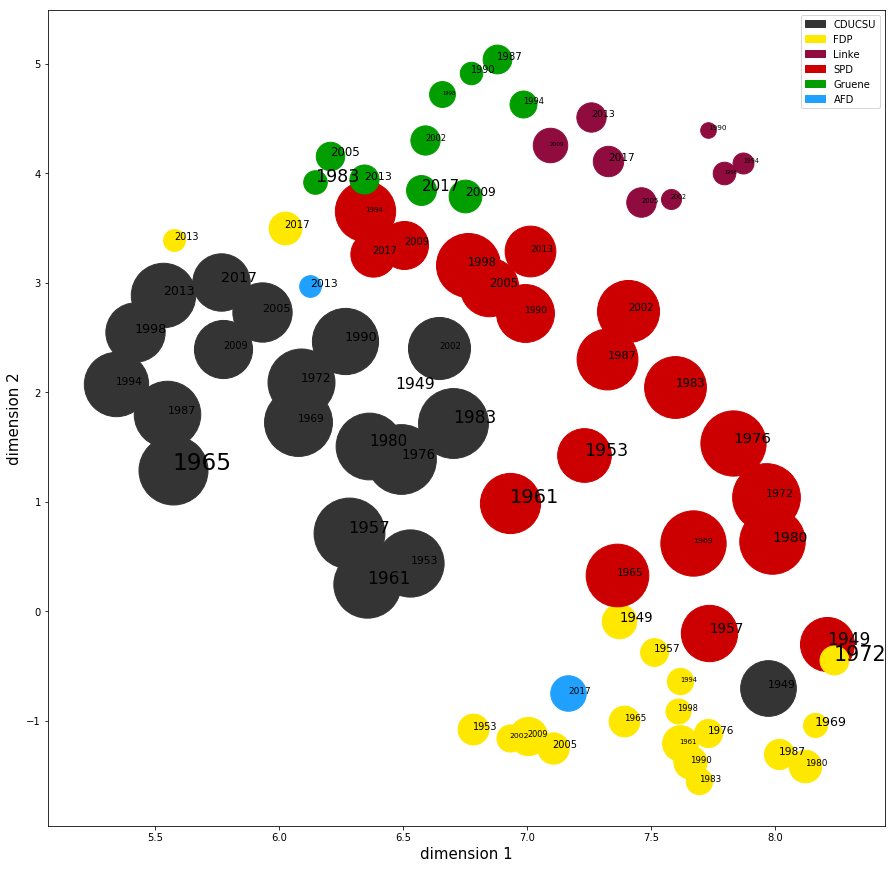

In [15]:
plot_scatter_data(dim_reduction(vectorized_df,method='UMAP'))

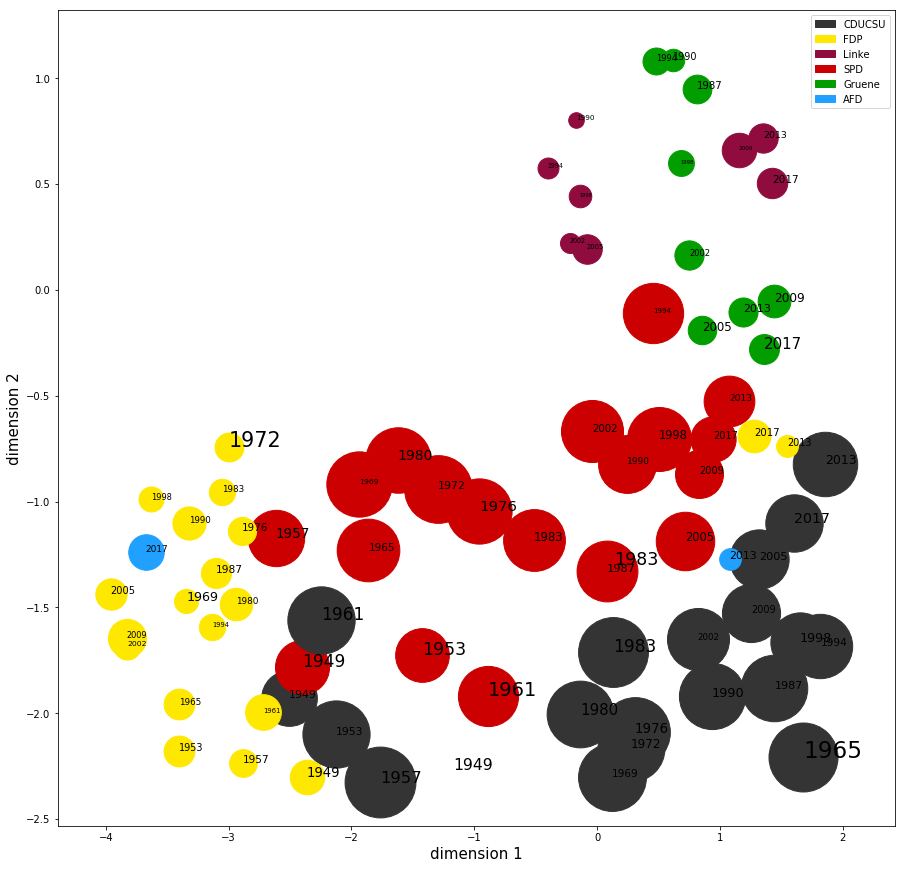

In [16]:
plot_scatter_data(dim_reduction(vectorized_df[interesting_words],method='UMAP'))

In [17]:
readability_df=df_from_readability_and_index(readability_scores,index)

In [18]:
b_df=df.loc[df['type'] == 'b']
partys=sorted(set(b_df['party_name']))
years=sorted((set(b_df['year'])))

party_results={}
for party in partys:
    party_res=[]
    for year in years:
        party_res.append(get_election_result(year,party))
    party_results[party]=party_res
    
result_df=pd.DataFrame(party_results).fillna(0)
result_df.index=years

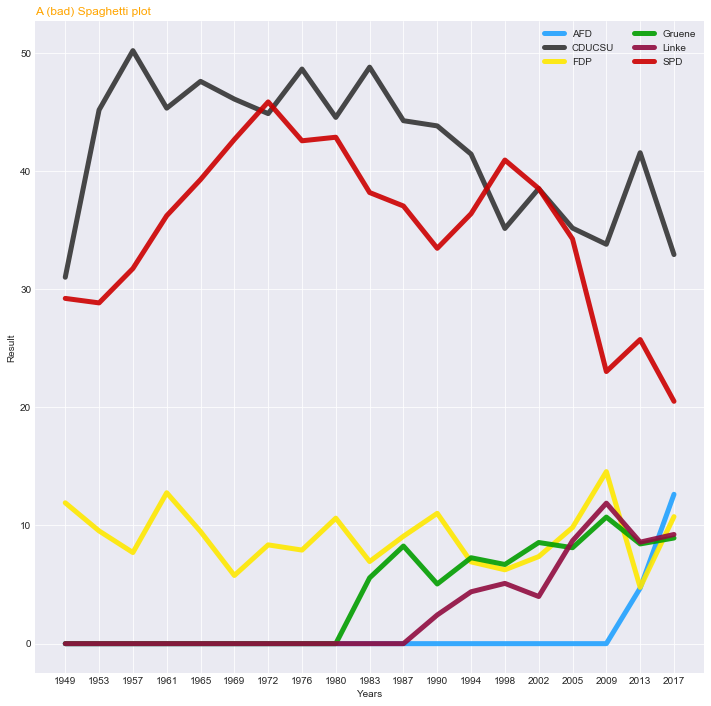

In [19]:
def plot_results(result_df):
    # style
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(12,12))
    # create a color palette
    palette = plt.get_cmap('Set1')

    # multiple line plot
    for column in result_df:
        plt.plot(result_df.index, result_df[column], marker='', color=color_of(column), linewidth=5, alpha=0.9, label=column)

    # Add legend
    plt.legend(loc=1, ncol=2)

    # Add titles
    plt.title("A (bad) Spaghetti plot", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("Years")
    plt.ylabel("Result")

plot_results(result_df)

/Users/hao/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


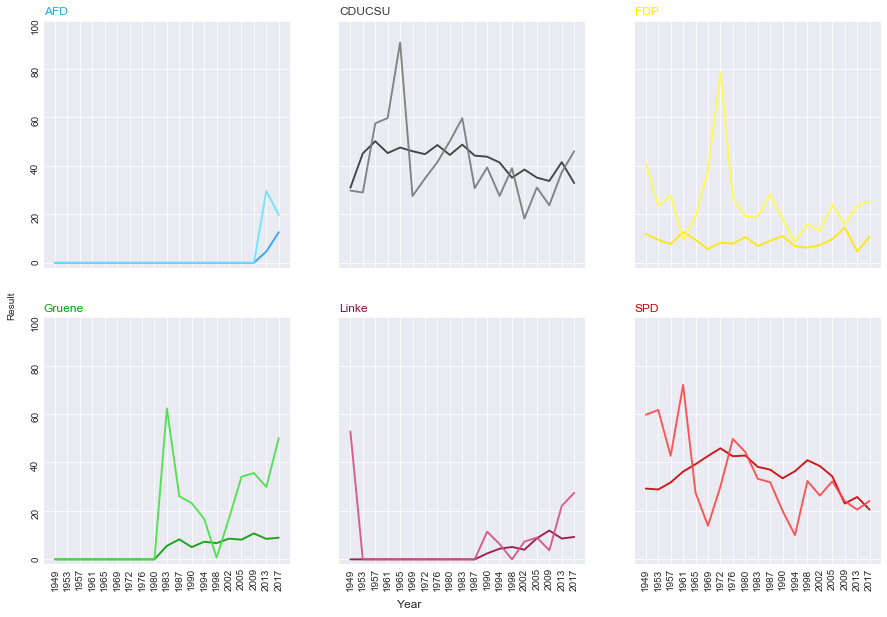

In [20]:
def plot_results_with_readability(result_df,readability_df):
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(15,10))
    # multiple line plot
    num=0
    for column in result_df:
        num+=1

        # Find the right spot on the plot
        plt.subplot(2,3, num)

        # Plot the lineplot
        plt.plot(result_df.index, result_df[column], marker='', color=color_of(column), linewidth=1.9, alpha=0.9, label=column)
        plt.plot(readability_df.index, readability_df[column], marker='', color=brighter_color_of(column), linewidth=1.9, alpha=0.9, label=column)


        #plt.xlim(0,)
        plt.ylim(-2,100)
        plt.tick_params(labelrotation=90)
        # Not ticks everywhere
        if num in [1,2,3] :
            plt.tick_params(labelbottom='off')
        if num not in [1,4] :
            plt.tick_params(labelleft='off')

        # Add title
        plt.title(column, loc='left', fontsize=12, fontweight=0, color=color_of(column) )
    # general title
    plt.suptitle('', fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

    # Axis title
    plt.text(-20, -20, 'Year',fontsize=12)
    plt.text(-51, 105, 'Result', ha='center', va='center', rotation='vertical')
    
plot_results_with_readability(result_df,readability_df)

In [21]:
test_df=vectorized_df[interesting_words]

In [22]:
test_df.transpose()

1949|CDUCSU  1949|FDP  1949|Linke  1949|SPD  \
strafrahmen                  0.000000  0.000000    0.000000  0.000000   
lärmbekämpfung               0.000000  0.000000    0.000000  0.000000   
dokumentationszentren        0.000000  0.000000    0.000000  0.000000   
lenkungsaufgaben             0.034815  0.000000    0.000000  0.000000   
seit                         0.000000  0.000000    0.000000  0.012851   
gericht                      0.000000  0.031492    0.000000  0.000000   
einverstanden                0.000000  0.030943    0.000000  0.000000   
flügel                       0.000000  0.000000    0.000000  0.000000   
umwelt                       0.000000  0.000000    0.000000  0.000000   
vollbringen                  0.000000  0.000000    0.000000  0.000000   
hinterbliebene               0.000000  0.022654    0.000000  0.000000   
gesellschaftsaufbau          0.000000  0.000000    0.000000  0.000000   
innenpolitik                 0.000000  0.000000    0.000000  0.000000   
verbundwirtschaft            0.000000  0.000000    0.000000  0.000000   
verbieten                    0.006256  0.000000    0.000000  0.000000   
windenergieanlagen           0.000000  0.000000    0.000000  0.000000   
bundestagsfraktion           0.000000  0.000000    0.000000  0.000000   
brandt                       0.000000  0.000000    0.000000  0.000000   
erlöschen                    0.000000  0.000000    0.000000  0.000000   
zeigen                       0.000000  0.004388    0.019914  0.000000   
erholungs                    0.000000  0.000000    0.000000  0.000000   
ehe                          0.000000  0.000000    0.000000  0.000000   
einfuhr                      0.000000  0.009544    0.000000  0.000000   
rettet                       0.000000  0.000000    0.000000  0.000000   
verkehren                    0.000000  0.000000    0.000000  0.000000   
schwermetall                 0.000000  0.000000    0.000000  0.000000   
einmütig                     0.000000  0.000000    0.000000  0.000000   
gesamthochschule             0.000000  0.000000    0.000000  0.000000   
bürgergesellschaft           0.000000  0.000000    0.000000  0.000000   
nung                         0.000000  0.000000    0.000000  0.000000   
...                               ...       ...         ...       ...   
schwarz                      0.000000  0.007250    0.000000  0.000000   
welt                         0.015466  0.020620    0.023393  0.000000   
abfallgesetzes               0.000000  0.000000    0.000000  0.000000   
zwingt                       0.000000  0.000000    0.000000  0.000000   
großbetrieblicher            0.000000  0.000000    0.000000  0.000000   
josef                        0.000000  0.000000    0.000000  0.000000   
angekün                      0.000000  0.000000    0.035104  0.000000   
verwirtschaftet              0.000000  0.000000    0.000000  0.000000   
partei                       0.000000  0.188006    0.049220  0.048841   
gemeinsinn                   0.000000  0.000000    0.000000  0.000000   
gesellschaftsvertrag         0.000000  0.000000    0.000000  0.000000   
entscheiden                  0.000000  0.003525    0.023993  0.057140   
gute                         0.000000  0.000000    0.000000  0.000000   
28september1969              0.000000  0.000000    0.000000  0.000000   
versorgung                   0.027747  0.020551    0.009326  0.000000   
aufstieg                     0.000000  0.006197    0.014060  0.000000   
energiequellen               0.000000  0.000000    0.000000  0.000000   
afd                          0.000000  0.000000    0.000000  0.000000   
bildungsaufgaben             0.000000  0.000000    0.000000  0.000000   
energiesparinvestitionen     0.000000  0.000000    0.000000  0.000000   
dabei                        0.008671  0.003854    0.000000  0.000000   
banken                       0.000000  0.000000    0.000000  0.000000   
rücklagen                    0.000000  0.033981    0.000000  0.000000   
alternativp

In [28]:
def word_cloud(df,party,year):
    tfidf_dict=(df.transpose()[f'{year}|{party}']+0.00001).to_dict()
    wordcloud = WordCloud(background_color=color_of(party), width=800, height=800).generate_from_frequencies(tfidf_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def result_words_df(df,year):

    results=[]
    columns=[]
    for party in partys:
        results.append(get_election_result('2017',party))
        columns.append(f'{year}|{party}')
    
    
    computed_df=(df.transpose()[columns]*np.array(results)).transpose()
    computed_df=(computed_df/computed_df.sum(axis=0)).fillna(0)
    return computed_df
#todo nan untersuchen
result_words_df(vectorized_df[interesting_words],'2017')

strafrahmen  lärmbekämpfung  dokumentationszentren  \
2017|AFD             0.0             0.0                    0.0   
2017|CDUCSU          0.0             0.0                    0.0   
2017|FDP             0.0             0.0                    0.0   
2017|Gruene          0.0             0.0                    0.0   
2017|Linke           0.0             0.0                    0.0   
2017|SPD             0.0             0.0                    0.0   

             lenkungsaufgaben      seit   gericht  einverstanden  flügel  \
2017|AFD                  0.0  0.126241  0.093090            0.0     0.0   
2017|CDUCSU               0.0  0.604609  0.000000            0.0     0.0   
2017|FDP                  0.0  0.044167  0.341971            0.0     0.0   
2017|Gruene               0.0  0.046900  0.103752            0.0     0.0   
2017|Linke                0.0  0.090889  0.075400            0.0     0.0   
2017|SPD                  0.0  0.087195  0.385787            0.0     0.0   

               umwelt  vollbringen    ...        dabei    banken  rücklagen  \
2017|AFD     0.054818          0.0    ...     0.023146  0.260812        1.0   
2017|CDUCSU  0.590716          0.0    ...     0.332567  0.000000        0.0   
2017|FDP     0.014384          0.0    ...     0.151838  0.097766        0.0   
2017|Gruene  0.103099          0.0    ...     0.099964  0.186867        0.0   
2017|Linke   0.066600          0.0    ...     0.068741  0.261544        0.0   
2017|SPD     0.170383          0.0    ...     0.323743  0.193011        0.0   

             alternativprojekte  leidende  solidarisch  gefestigt  den  \
2017|AFD                    0.0       0.0     0.000000        0.0  0.0   
2017|CDUCSU                 0.0       0.0     0.091314        1.0  0.0   
2017|FDP                    0.0       0.0     0.000000        0.0  0.0   
2017|Gruene                 0.0       0.0     0.194788        0.0  1.0   
2017|Linke                  0.0       0.0     0.351751        0.0  0.0   
2017|SPD                    0.0       0.0     0.362147        0.0  0.0   

             daseinsgrundlage    privat  
2017|AFD                  0.0  0.155410  
2017|CDUCSU               0.0  0.309176  
2017|FDP                  0.0  0.175664  
2017|Gruene               0.0  0.076612  
2017|Linke                0.0  0.109738  
2017|SPD                  0.0  0.173400  

[6 rows x 2413 columns]

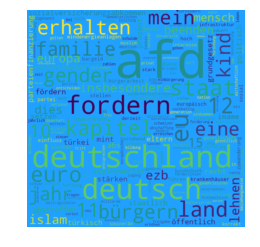

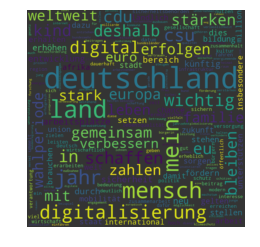

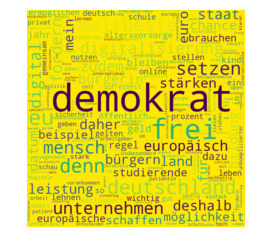

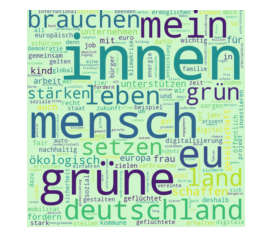

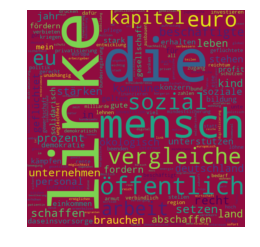

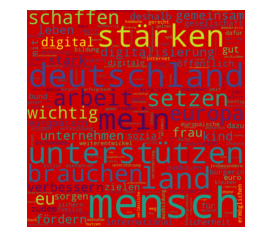

In [40]:
for party in partys:
    word_cloud(test_df.drop(columns=['der', 'ich']),party,'2017')

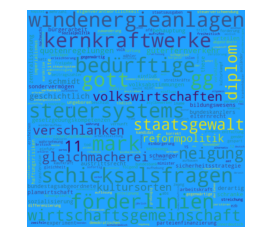

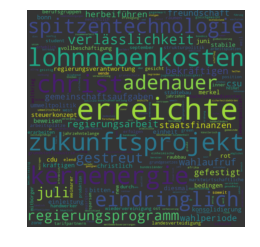

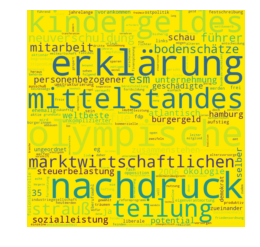

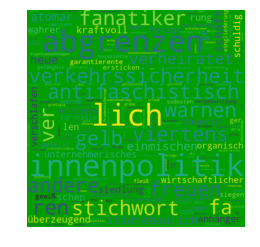

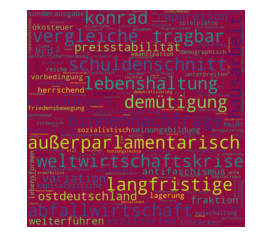

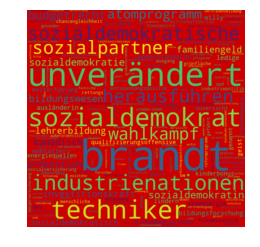

In [36]:
for party in partys:
    word_cloud(result_words_df(vectorized_df[interesting_words],'2017'),party,'2017')

In [24]:
def heatmap(x, y, size,color,figsize):
    fig, ax = plt.subplots(figsize=figsize)
    fig
    # Mapping from column names to integer coordinates
    x_labels = x
    y_labels = y
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}
    
    x_scatter=[]
    y_scatter=[]
    for i, y_label in enumerate(y_labels):
        for j, x_label in enumerate(x_labels):
            x_scatter.append(j)
            y_scatter.append(i)
    
    size_scale = 500
    
    ax.scatter(
        x=x_scatter, # Use mapping for x
        y=y_scatter, # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color,
        marker='o' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])


In [54]:
def piemap(x, y, size,ratios,figsize):
    fig, ax = plt.subplots(figsize=figsize)
    fig
    # Mapping from column names to integer coordinates
    x_labels = x
    y_labels = y
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}
    
    x_scatter=[]
    y_scatter=[]
    for i, y_label in enumerate(y_labels):
        for j, x_label in enumerate(x_labels):
            x_scatter.append(j)
            y_scatter.append(i)
    
    colors=[color_of(party) for party in partys]

    for i,_ in enumerate(x_scatter):
        ax.pie(ratios[i], colors=colors,
               center=(x_scatter[i], y_scatter[i]), radius=size[i], frame=True)

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])


In [26]:
test_df.head()

wettbewerb  bürgergeld  juliusturm  christ  arbeiterschaft  \
1949|CDUCSU    0.049804         0.0         0.0     0.0             0.0   
1949|FDP       0.004455         0.0         0.0     0.0             0.0   
1949|Linke     0.000000         0.0         0.0     0.0             0.0   
1949|SPD       0.000000         0.0         0.0     0.0             0.0   
1953|CDUCSU    0.042153         0.0         0.0     0.0             0.0   

             gleichstellung  klimawandel  position  rainer  bekennen  ...  \
1949|CDUCSU        0.006144          0.0       0.0     0.0  0.012127  ...   
1949|FDP           0.004947          0.0       0.0     0.0  0.004882  ...   
1949|Linke         0.000000          0.0       0.0     0.0  0.000000  ...   
1949|SPD           0.013495          0.0       0.0     0.0  0.000000  ...   
1953|CDUCSU        0.009360          0.0       0.0     0.0  0.009237  ...   

             wahlaufruf  ordentlich  ausschüttung  aufopfern  erfolgreich  \
1949|CDUCSU         0.0    0.000000           0.0        0.0     0.017260   
1949|FDP            0.0    0.045148           0.0        0.0     0.004632   
1949|Linke          0.0    0.000000           0.0        0.0     0.000000   
1949|SPD            0.0    0.000000           0.0        0.0     0.025272   
1953|CDUCSU         0.0    0.000000           0.0        0.0     0.026295   

             vergossen    mittel  christlich  vielfalt  erklären  
1949|CDUCSU        0.0  0.060092    0.008562  0.000000  0.000000  
1949|FDP           0.0  0.021991    0.027572  0.004882  0.000000  
1949|Linke         0.0  0.019625    0.000000  0.000000  0.000000  
1949|SPD           0.0  0.011998    0.056412  0.000000  0.017931  
1953|CDUCSU        0.0  0.041613    0.065217  0.000000  0.000000  

[5 rows x 2598 columns]

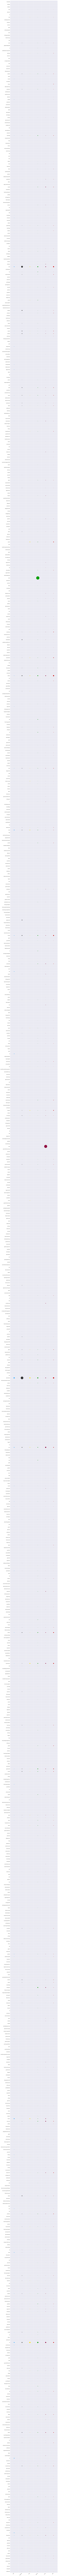

In [27]:
def plot_words_for_year(year,df,n=1000):
    colors=[]
    sizes=[]
    words=df.columns[:n]
    partys=sorted(set([index.split('|')[1] for index in df.index]))
    
    for i, y_label in enumerate(words):
        for j, party in enumerate(partys):
            colors.append(color_of(party))
            try:
                sizes.append((df[y_label][f'{year}|{party}']*100)**2)
            except KeyError:
                sizes.append(0)
    
    heatmap(
        x=pd.Series(partys),
        y=pd.Series(words),
        size=sizes,
        color=colors,
        figsize=(len(partys)*2,len(words)/1.5)
    )
    
plot_words_for_year('2017',test_df)

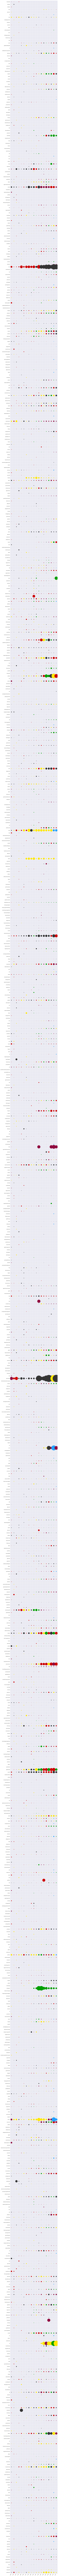

In [28]:
def plot_words_for_all_years(df,n=1000):
    colors=[]
    sizes=[]
    words=df.columns[:n]
    partys=sorted(set([index.split('|')[1] for index in df.index]))
    years=sorted(set([index.split('|')[0] for index in df.index]))
    
    for i, y_label in enumerate(words):
        for j, year in enumerate(years):
            summe=0
            max_party='AFD'
            max_value=0
            for k, party in enumerate(partys):
                try:
                    summand=df[y_label][f'{year}|{party}']

                    if summand>max_value:
                        max_value=summand
                        max_party=party

                    summe+=summand
                    max_party
                except KeyError:
                    summe+=0
            
            colors.append(color_of(max_party))
            sizes.append((summe*100)**2)
            
            

    heatmap(
        x=pd.Series(years),
        y=pd.Series(words),
        size=sizes,
        color=colors,
        figsize=(len(partys)*2,len(words)/1.5)
    )
    
plot_words_for_all_years(test_df)

D:\Anaconda\envs\stdenv\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


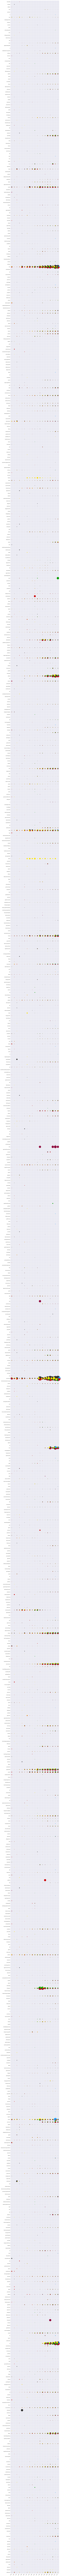

In [74]:
def plot_words_for_all_years(df,n=1000):
    colors=[]
    sizes=[]
    words=df.columns[:n]
    partys=sorted(set([index.split('|')[1] for index in df.index]))
    years=sorted(set([index.split('|')[0] for index in df.index]))
    ratios=[]
    for i, y_label in enumerate(words):
        
        for j, year in enumerate(years):
            summe=0
            max_party='AFD'
            max_value=0
            ratio=[]
            for k, party in enumerate(partys):
                try:
                    summand=df[y_label][f'{year}|{party}']

                    summe+=summand
                    ratio.append(summand)
                except KeyError:
                    summe+=0
                    ratio.append(0)
                    
            ratio=np.array(ratio)
            ratios.append(np.nan_to_num(ratio/ratio.sum()))
            sizes.append(summe)
            
    piemap(
        x=pd.Series(years),
        y=pd.Series(words),
        size=sizes,
        ratios=ratios,
        figsize=(len(partys)*2,len(words)/1.5)
    )
    
plot_words_for_all_years(test_df)